In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
import xml.etree.ElementTree as et
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import IPython
import IPython.display

# Read in all of the Data

In [8]:
train_datapath = '../../OhioT1DM/data/train/'
test_datapath = '../../OhioT1DM/data/test/'
data_of_interest = [['GlucoseLevel','./glucose_level/event'],
                    ['Basal', './basal/event'],
                    ['Bolus', './bolus/event'],
                    ['Meal', './meal/event'],
                    ['Sleep', './sleep/event']]

In [9]:
def read_all_patient_data(datapath):
    files = os.listdir(datapath)
    all_file_data = {}
    for k,filename in enumerate(files):
        patient_id = filename[0:3]
        temp_data = {}
        for datapoint, xml_path in data_of_interest:
            try:
                data = pd.read_xml(datapath + filename, xpath=xml_path)
                data['ts'] = pd.to_datetime(data['ts'], format='%d-%m-%Y %H:%M:%S')
                data = data.set_index('ts')
                temp_data[datapoint] = data
            except:
                temp_data[datapoint] = pd.DataFrame()
        all_file_data[patient_id] = temp_data
    return all_file_data

all_training_data = read_all_patient_data(train_datapath)
all_testing_data = read_all_patient_data(test_datapath)


Empty DataFrame
Columns: []
Index: []
                     value
ts                        
2021-09-13 09:40:35    1.1
2021-09-13 10:30:00    0.9
2021-09-13 11:30:00    0.6
2021-09-13 18:00:00    0.7
2021-09-14 00:00:00    1.5
...                    ...
2021-10-25 03:00:00    1.6
2021-10-25 07:30:00    1.3
2021-10-25 10:00:00    1.2
2021-10-25 11:30:00    0.7
2021-10-25 18:30:00    0.8

[87 rows x 1 columns]


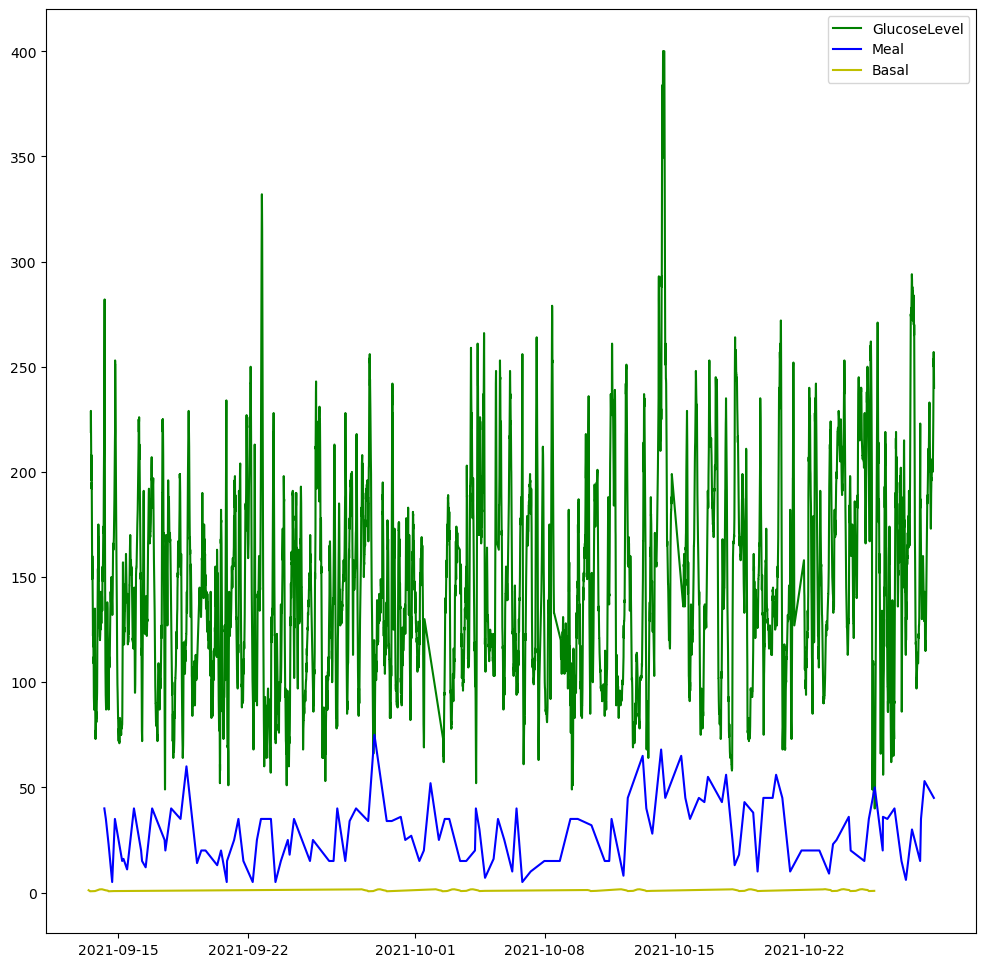

In [10]:
data_to_plot = all_training_data['563']
print(data_to_plot['Bolus'])
print(data_to_plot['Basal'])

fig, ax = plt.subplots(figsize=(12,12))

ax.plot(data_to_plot['GlucoseLevel']['value'], label='GlucoseLevel', c='g')
ax.plot(data_to_plot['Meal']['carbs'], label='Meal', c='b')
ax.plot(data_to_plot['Basal']['value'], label='Basal', c='y')

ax.legend()
plt.show()

# Setup Data for First Predction
#### Will use Patient 563 for preliminary testing with only Blood Glucose Level

In [11]:
train_data_563 = all_training_data['563']['GlucoseLevel']
test_data_563 = all_testing_data['563']['GlucoseLevel']

In [12]:
train_data_563.describe()

,value
count,12124.00000
mean,146.07712
std,49.68904
min,40.00000
25%,108.00000
50%,140.00000
75%,177.00000
max,400.00000


In [13]:
test_data_563.describe()

,value
count,2570.000000
mean,167.372374
std,46.138496
min,62.000000
25%,134.000000
50%,167.000000
75%,195.000000
max,313.000000


In [14]:
# # Perform some Min-Max scaling on features of training data
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(train_data_563)
# train_data_563['value'] = scaled
# train_data_563.describe()

In [15]:
# scaled_test = scaler.fit_transform(test_data_563)
# test_data_563['value'] = scaled_test
# test_data_563.describe()

# Class to Generate Windows from Data

In [16]:
class PredictionRangeGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df, test_df, label_columns=None):
        
        # Store data in Generator
        self.train_df = train_df
        self.test_df = test_df
        
        #Work out column indices for different labels
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name : i for i, name in 
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
        # Work out window params
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:,:, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
        
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='value', all_data=False, max_subplots=2):
        inputs, labels = self.example
        #if all_data:
        #    inputs,labels = 
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

            plt.xlabel('Time [index]')
        
        
    def make_dataset(self, data, shuffle):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=32,)
        
        ds = ds.map(self.split_window)
        
        return ds
        
    @property
    def train(self):
        return self.make_dataset(self.train_df, True)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df, False)
    
    @property
    def example(self):
        """Get and cache an example batch for plotting"""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch found, so get one from train df
            result = next(iter(self.train))
            self._example = result
        return result

In [17]:
# Start off by predicting 30 minutes into the future
# Using the last 30 minutes of data
thirty_range = PredictionRangeGenerator(input_width=6, 
                               label_width=1, shift=6,
                               train_df=train_data_563, 
                               test_df=test_data_563,
                               label_columns=['value'])

thirty_range

Total window size: 12
Input indices: [0 1 2 3 4 5]
Label indices: [11]
Label column name(s): ['value']

2023-02-23 14:10:25.495215: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-23 14:10:25.495446: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-23 14:10:25.495479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Dan): /proc/driver/nvidia/version does not exist
2023-02-23 14:10:25.497151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


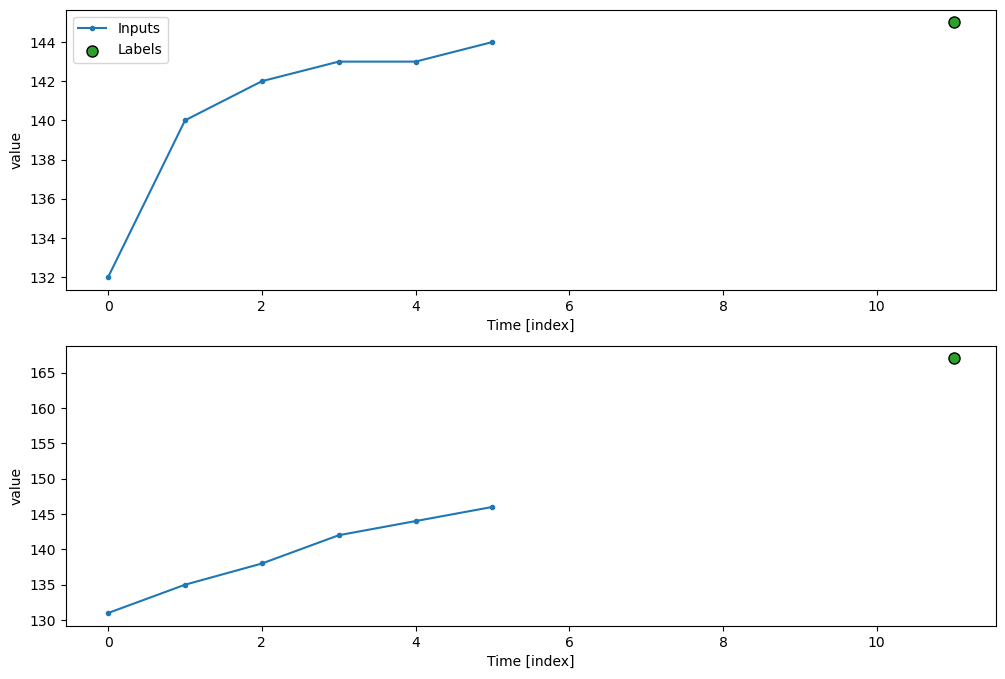

In [18]:
thirty_range.plot()

# Setup a Baseline to test Prediction Against
Baseline model will predict next value as previous value

In [19]:
class LinearBaseline(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
    def call(self, inputs):
        """
        Simply returns next value
        """
        return inputs[:, -1, tf.newaxis]

In [20]:
linear_base = LinearBaseline()
linear_base.compile(loss=tf.keras.losses.MeanSquaredError(),
                   metrics=[tf.keras.metrics.RootMeanSquaredError()])

linear_base.evaluate(thirty_range.test)

80/80 [==============================] - 0s 1ms/step - loss: 431.8566 - root_mean_squared_error: 20.7812


[431.8565979003906, 20.781160354614258]

In [21]:
print('Input shape:', thirty_range.example[0].shape)
print('Output shape:', linear_base(thirty_range.example[0]).shape)

Input shape: (32, 6, 1)
Output shape: (32, 1, 1)


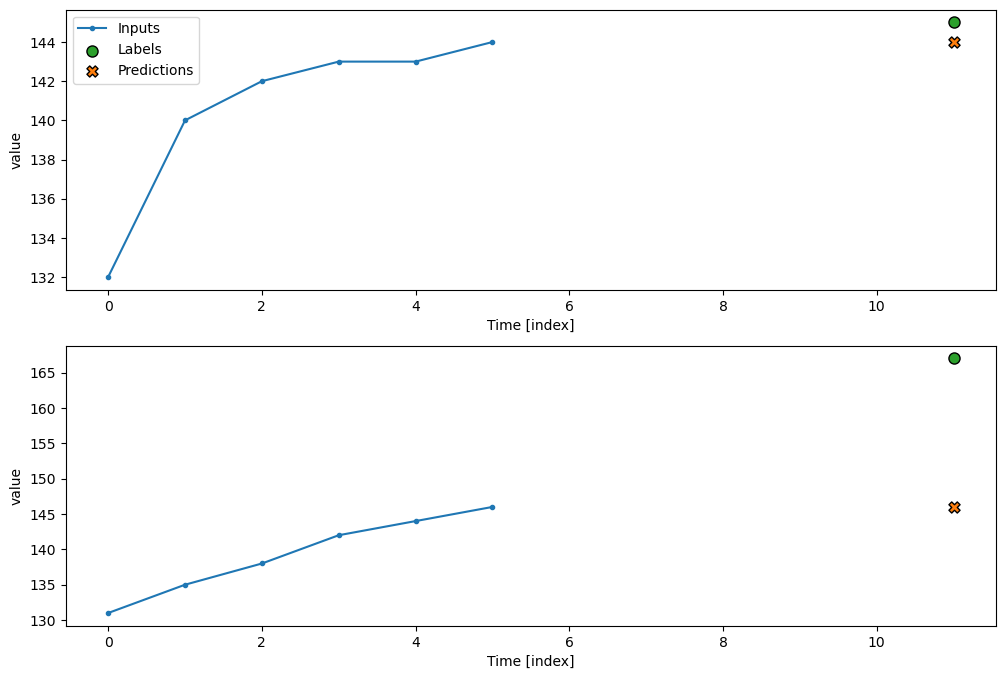

In [22]:
thirty_range.plot(linear_base)

# Try some Neural Nets for this basic prediction
### Multi-Layer Perceptron

In [23]:
# Setup function to train model on training data

def fit_model(model, predict_range, MAX_EPOCHS=20):
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError(),
                        tf.keras.metrics.MeanAbsoluteError()])

    model_history = model.fit(predict_range.train, epochs=MAX_EPOCHS)
    return model_history

In [24]:
five_range = PredictionRangeGenerator(
    input_width=12,
    label_width=1,
    shift=1,
    label_columns=['value'],
    train_df = train_data_563,
    test_df = test_data_563
)

In [25]:
mlp = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1,-1])
])

In [26]:
print('Input shape:', thirty_range.example[0].shape)
print('Output shape:', mlp(thirty_range.example[0]).shape)

Input shape: (32, 6, 1)
Output shape: (32, 1, 1)


In [27]:
# fit_model(mlp, five_range)

In [28]:
# five_range.plot(mlp, max_subplots=5)

In [30]:
# mlp.evaluate(five_range.train)

In [31]:
# linear_base.evaluate(five_range.train)

# LSTM on a wider window

In [33]:
half_hour_range = PredictionRangeGenerator(
    input_width=6,
    label_width=1,
    shift=3,
    label_columns=['value'],
    train_df = train_data_563,
    test_df = test_data_563
)

hour_range = PredictionRangeGenerator(
    input_width=12,
    label_width=12,
    shift=12,
    label_columns=['value'],
    train_df = train_data_563,
    test_df = test_data_563
)

six_hour_range = PredictionRangeGenerator(
    input_width=12,
    label_width=1,
    shift=72,
    label_columns=['value'],
    train_df = train_data_563,
    test_df = test_data_563
)

# Implement a model that predicts the change, not the value

In [34]:
class ChangePredictionLayer(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def call(self, inputs, *args, **kwargs):
        change = self.model(inputs, *args, **kwargs)
        return inputs + change

In [35]:
# def create_change_lstm(output_length, num_units=32):
#     return ChangePredictionLayer(
#         tf.keras.Sequential([
#         tf.keras.layers.LSTM(num_units, return_sequences=False),
#         tf.keras.layers.Dense(output_length,
#           kernel_initializer=tf.initializers.zeros()),
#         # Shape => [batch, out_steps, features].
#         tf.keras.layers.Reshape([output_length, 1])
#     ]))


def create_normal_lstm(output_length, num_units=128):
    return tf.keras.models.Sequential([
        tf.keras.layers.LSTM(num_units, return_sequences=False),
        tf.keras.layers.Dense(output_length,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([output_length, 1])
    ])

In [36]:
half_hour_range

Total window size: 9
Input indices: [0 1 2 3 4 5]
Label indices: [8]
Label column name(s): ['value']

In [37]:
hour_range

Total window size: 24
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [12 13 14 15 16 17 18 19 20 21 22 23]
Label column name(s): ['value']

In [38]:
six_hour_range

Total window size: 84
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [83]
Label column name(s): ['value']

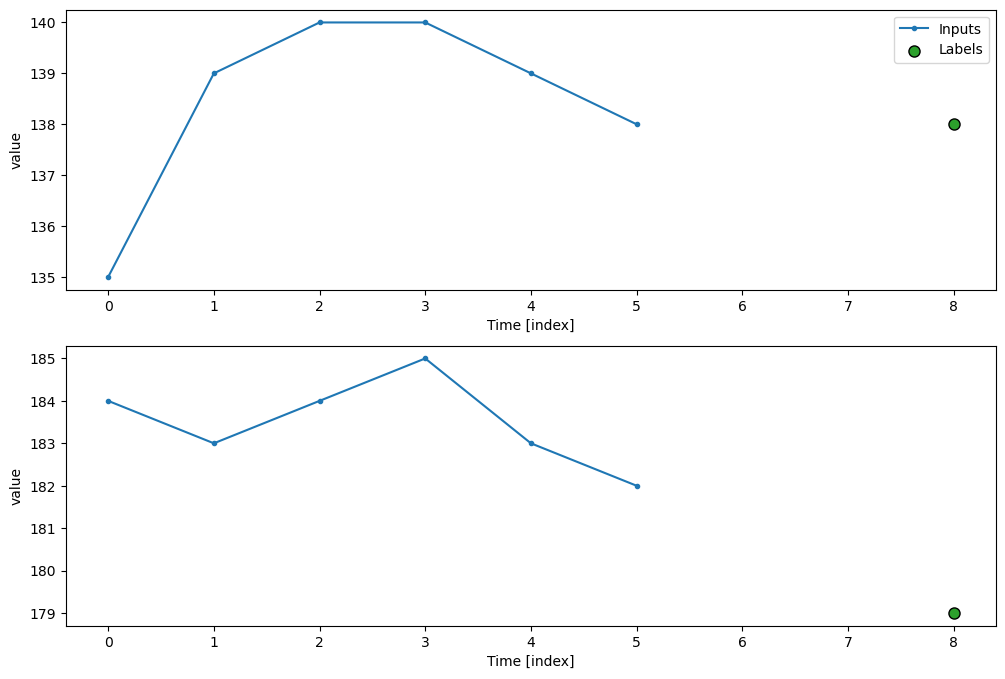

In [39]:
half_hour_range.plot()

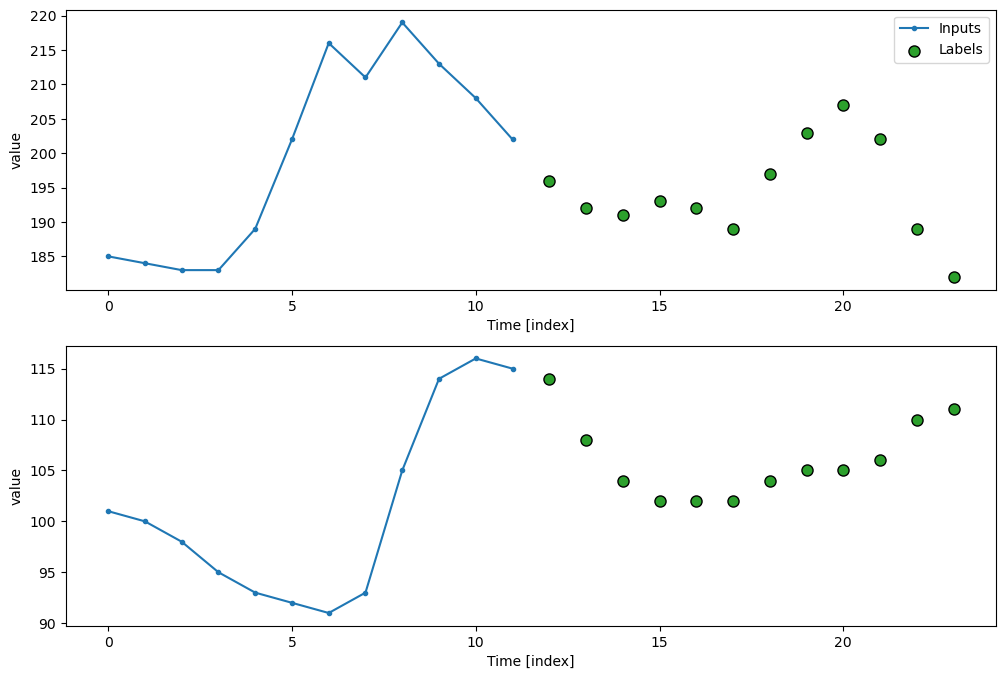

In [40]:
hour_range.plot()

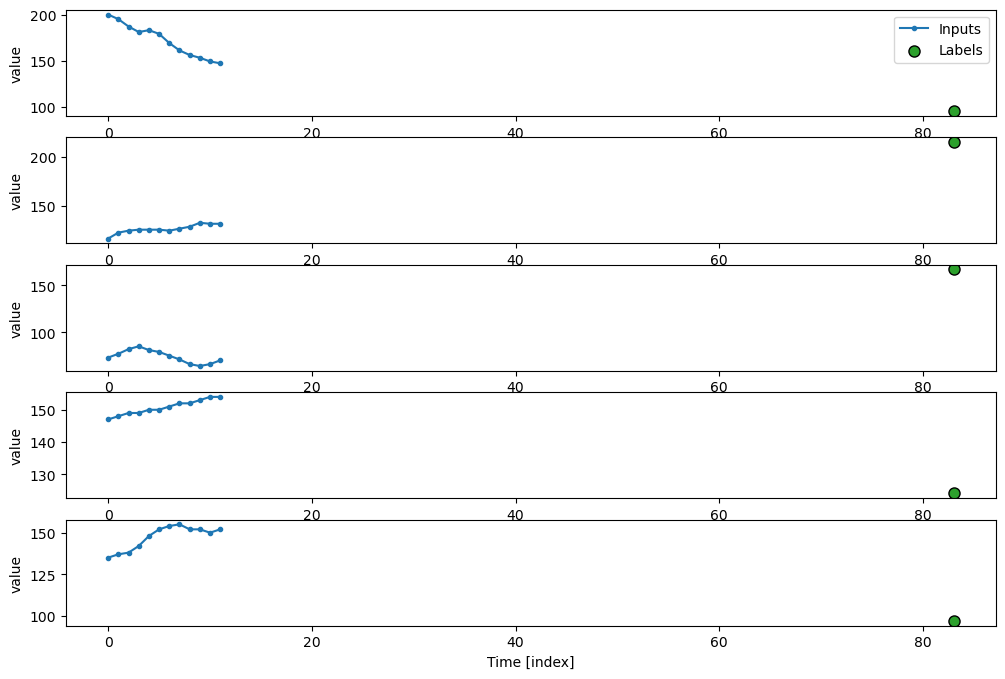

In [41]:
six_hour_range.plot(max_subplots=5)

In [42]:
normal_lstm_half_hour = create_normal_lstm(1)
normal_lstm_hour = create_normal_lstm(12)
normal_lstm_six_hour = create_normal_lstm(1)

In [43]:
for example_inputs, example_labels in half_hour_range.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
print("Input shape: ", half_hour_range.example[0].shape)
print('Output shape:', normal_lstm_half_hour(half_hour_range.example[0]).shape)

In [44]:
fit_model(normal_lstm_half_hour, half_hour_range, 40)
IPython.display.clear_output()

In [45]:
normal_lstm_half_hour.evaluate(half_hour_range.test)

81/81 [==============================] - 1s 3ms/step - loss: 159.2715 - root_mean_squared_error: 12.6203 - mean_absolute_error: 7.6868


[159.2715301513672, 12.620282173156738, 7.686792373657227]

In [ ]:
linear_base.evaluate(half_hour_range.test)

In [ ]:
half_hour_range.plot(normal_lstm_half_hour, max_subplots=5)

In [ ]:
fit_model(normal_lstm_hour, hour_range)
IPython.display.clear_output()

In [ ]:
normal_lstm_hour.evaluate(hour_range.test)

In [ ]:
hour_range.plot(normal_lstm_hour, max_subplots=5)

In [ ]:
fit_model(normal_lstm_six_hour, six_hour_range, 14)
IPython.display.clear_output()

In [ ]:
normal_lstm_six_hour.evaluate(six_hour_range.test)

In [ ]:
six_hour_range.plot(normal_lstm_six_hour, max_subplots=5)

In [46]:
def plot_model_predictions(model, pred_range, num_graphs=3):
    all_inputs = np.concatenate([x for x,y  in half_hour_range.test], axis=0)
    all_labels = np.concatenate([y for x,y in half_hour_range.test], axis=0)
    size = len(all_inputs)
    graph_size = size // num_graphs
    index = 0
    for i in range(num_graphs):
        cur_slice = slice(index, index+graph_size)
        if i == (num_graphs - 1):
            cur_slice = slice(index, size)
        cur_inputs = all_inputs[cur_slice]
        cur_labels = all_labels[cur_slice]
        index += graph_size
        predictions = model(cur_inputs)
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.plot(list(range(len(predictions.numpy()))), predictions.numpy().reshape(-1), 'g', linestyle='dashed')
        plt.plot(list(range(len(cur_labels))), cur_labels.reshape(-1), '-')
    

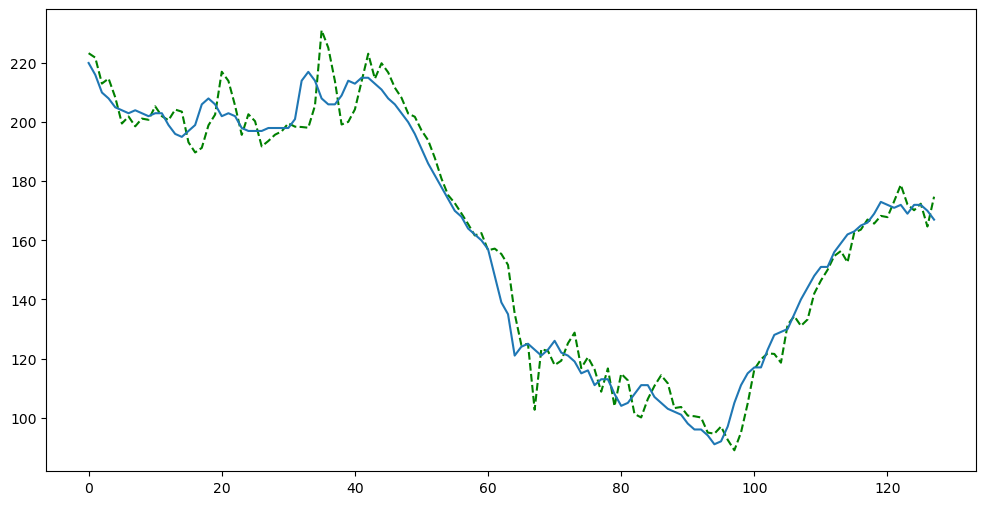

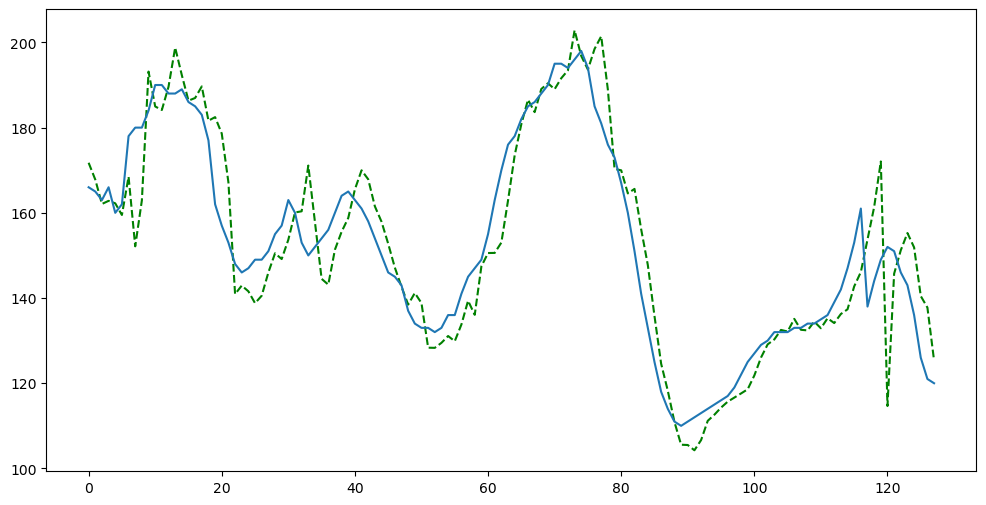

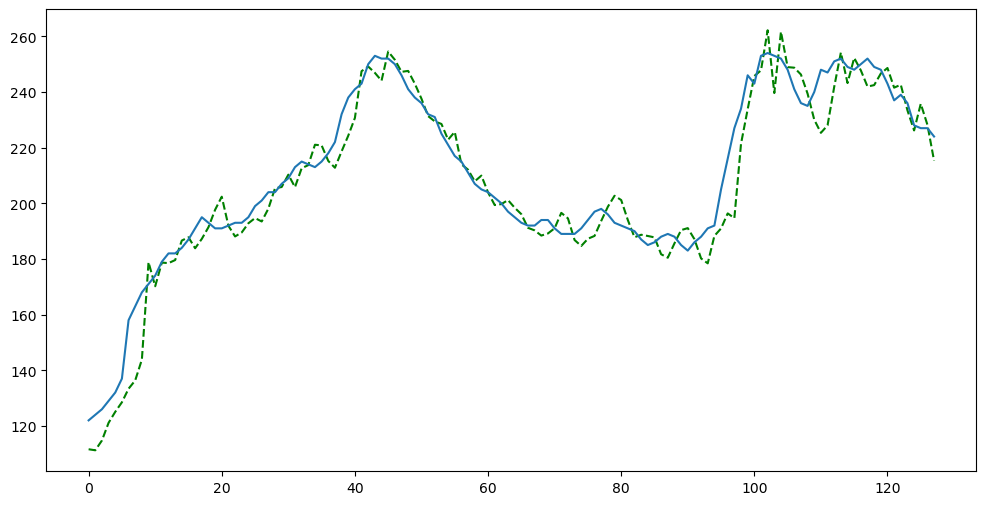

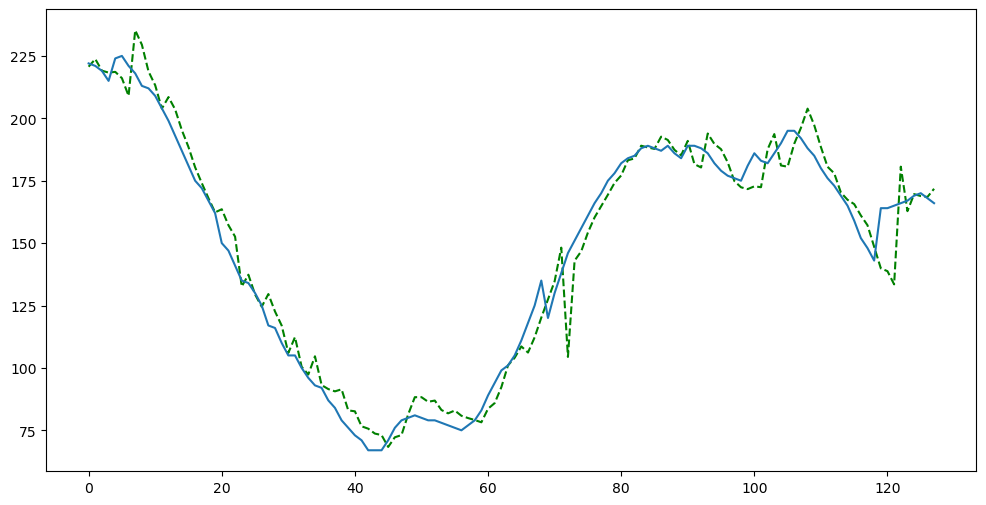

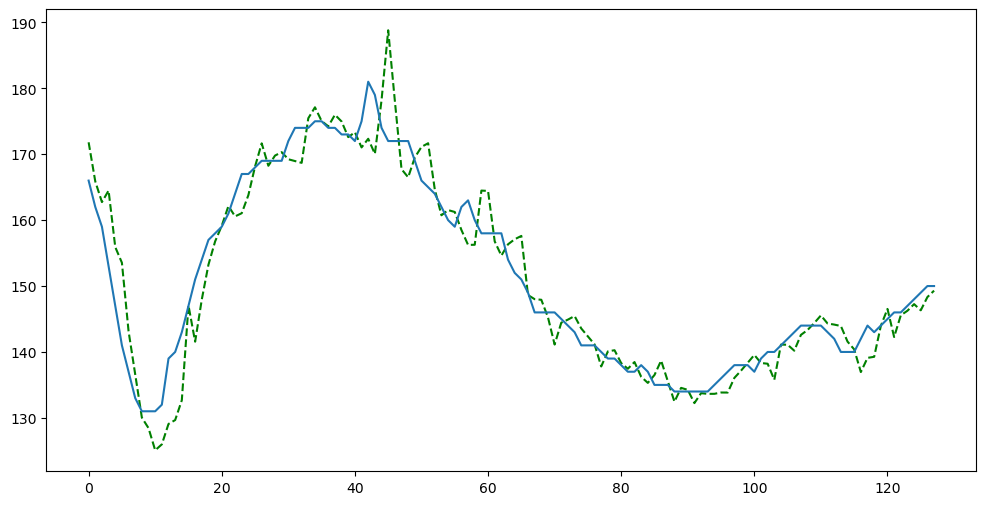

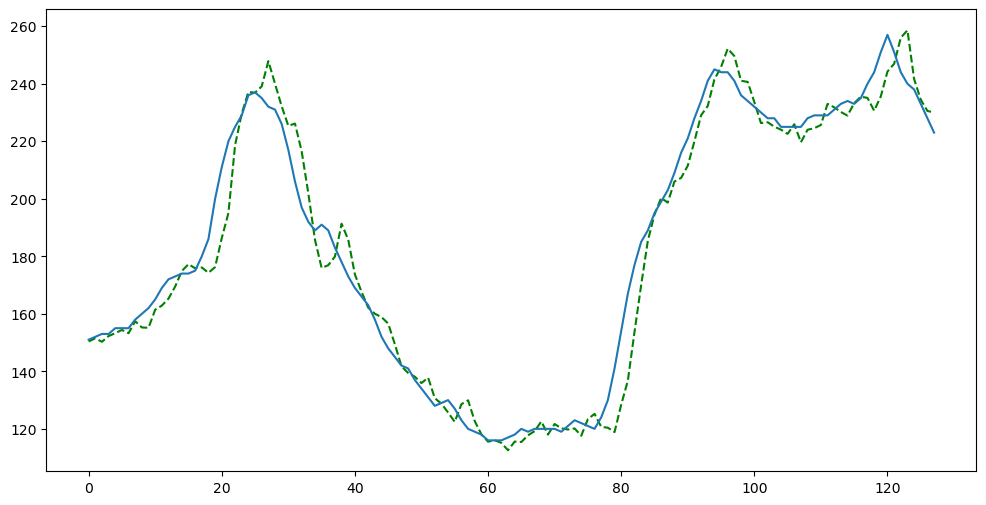

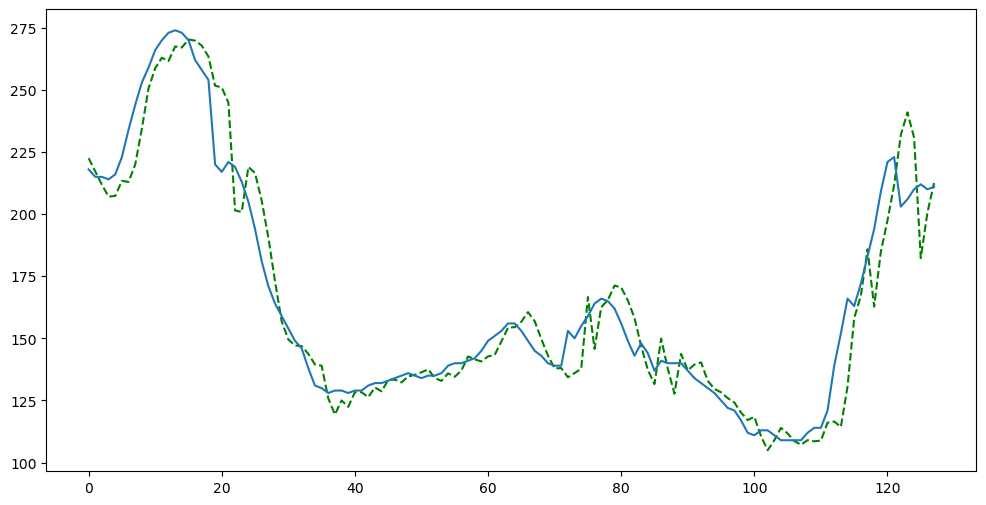

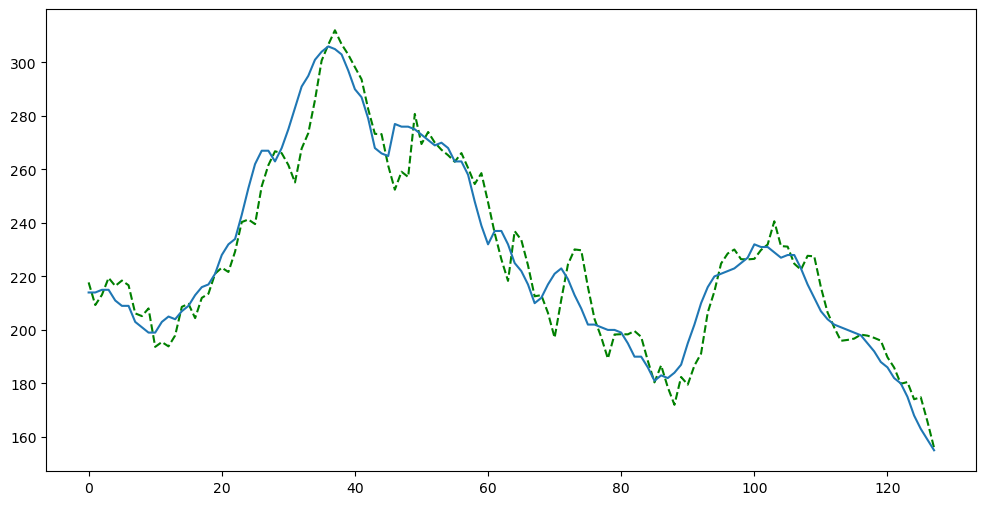

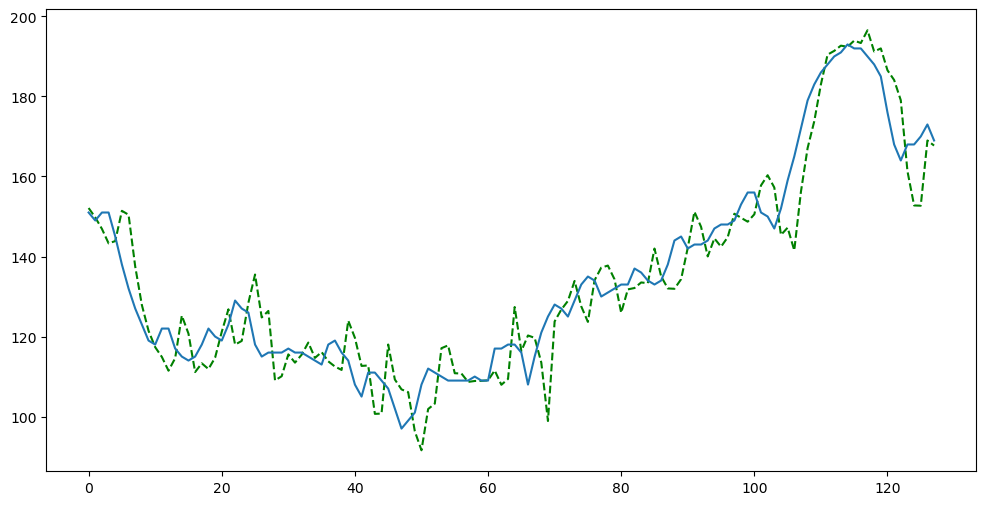

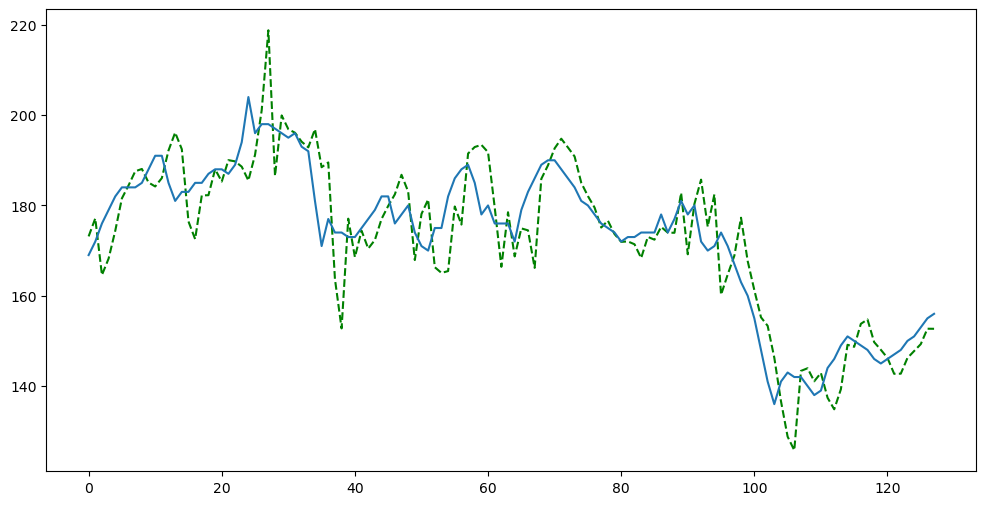

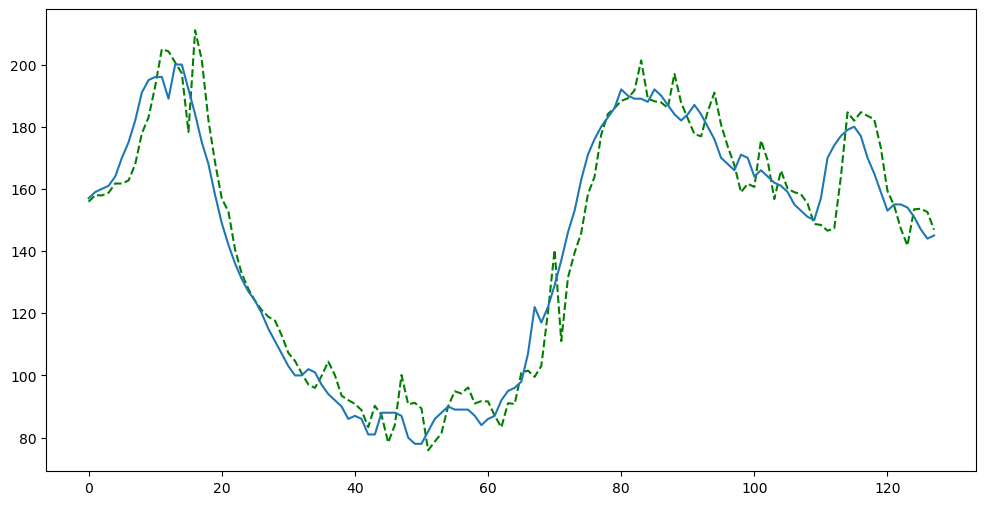

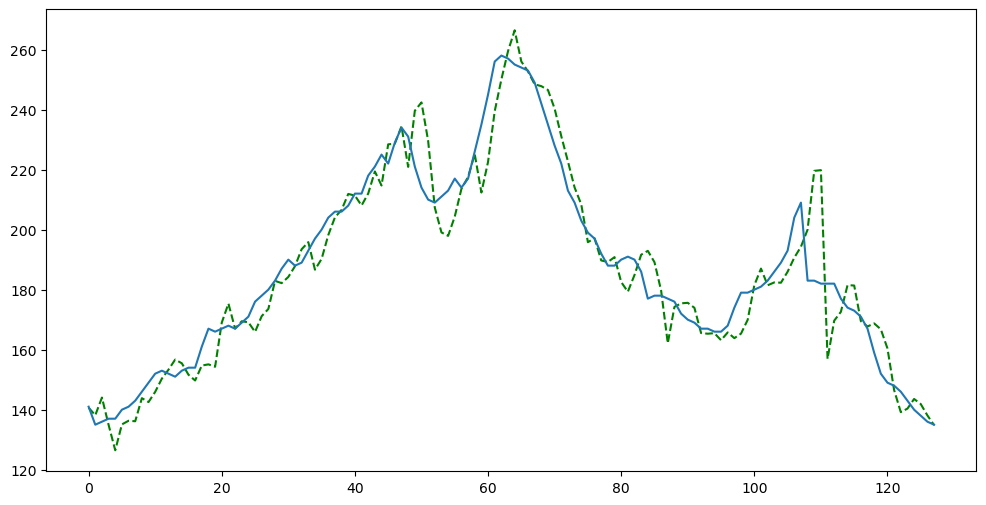

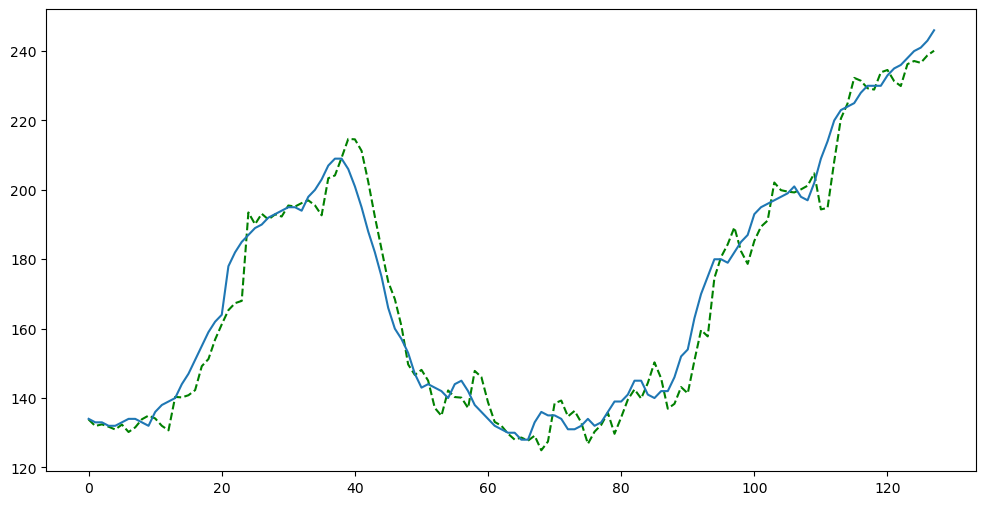

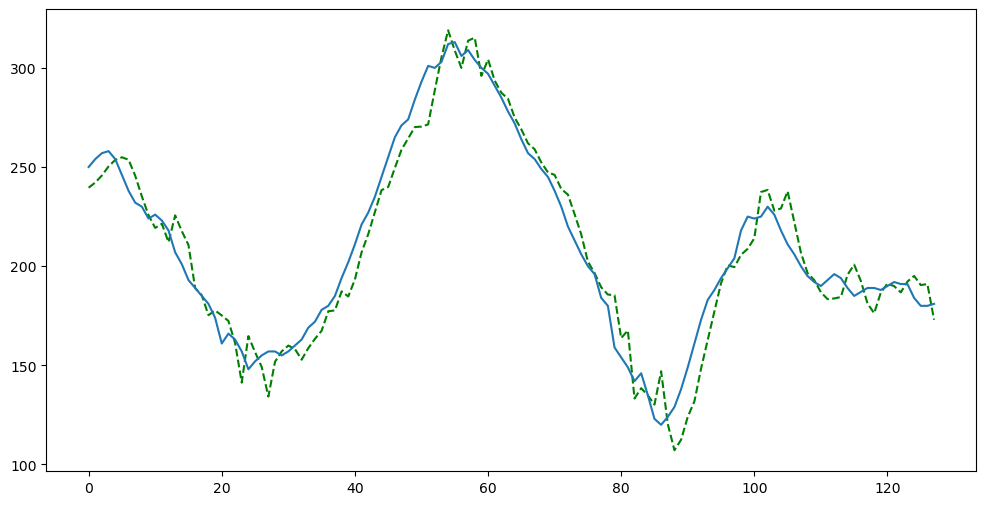

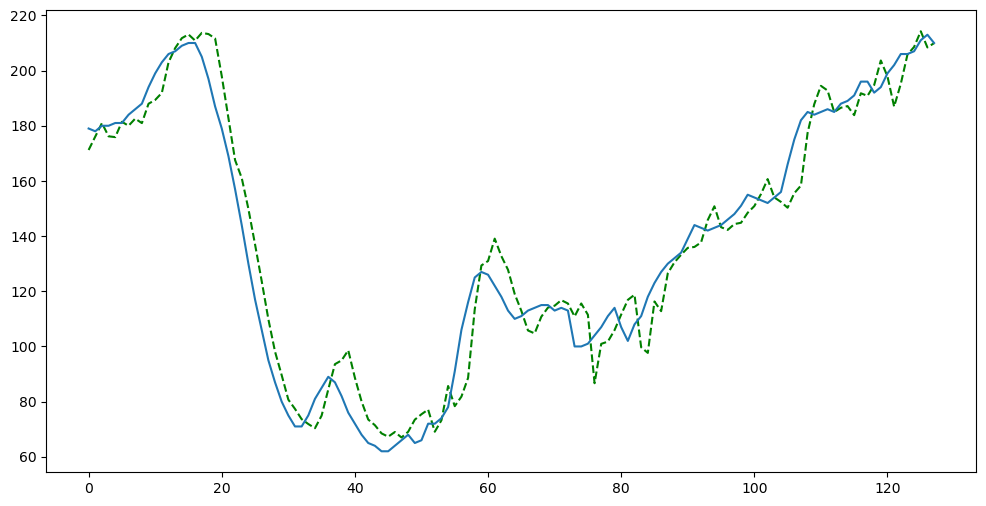

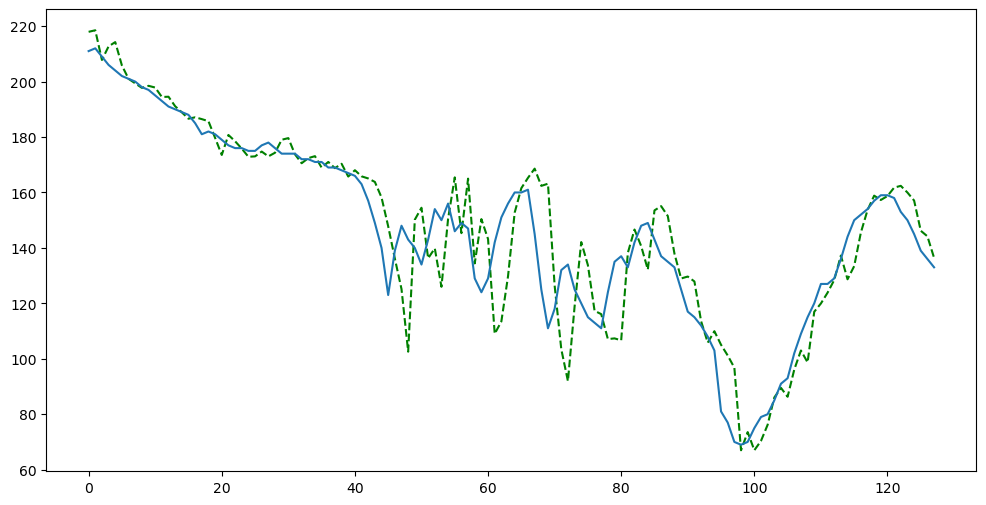

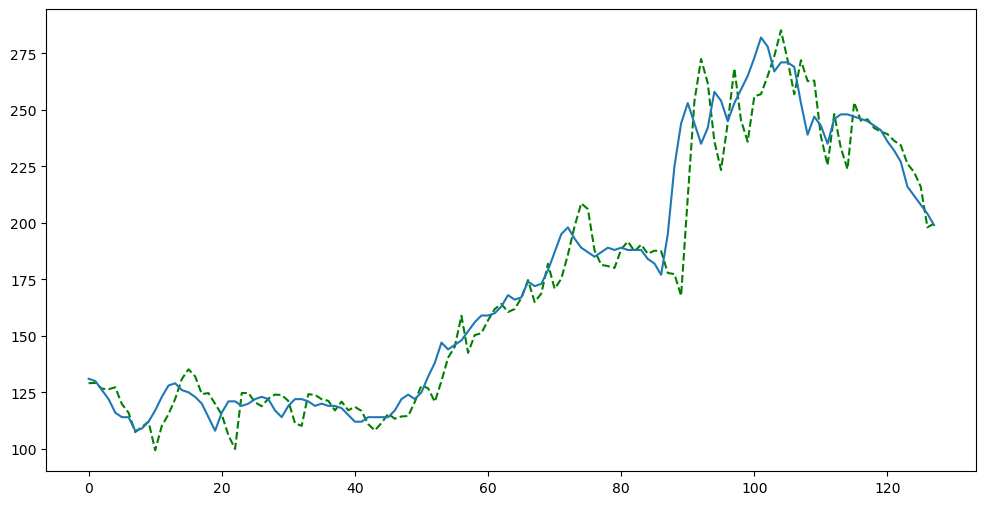

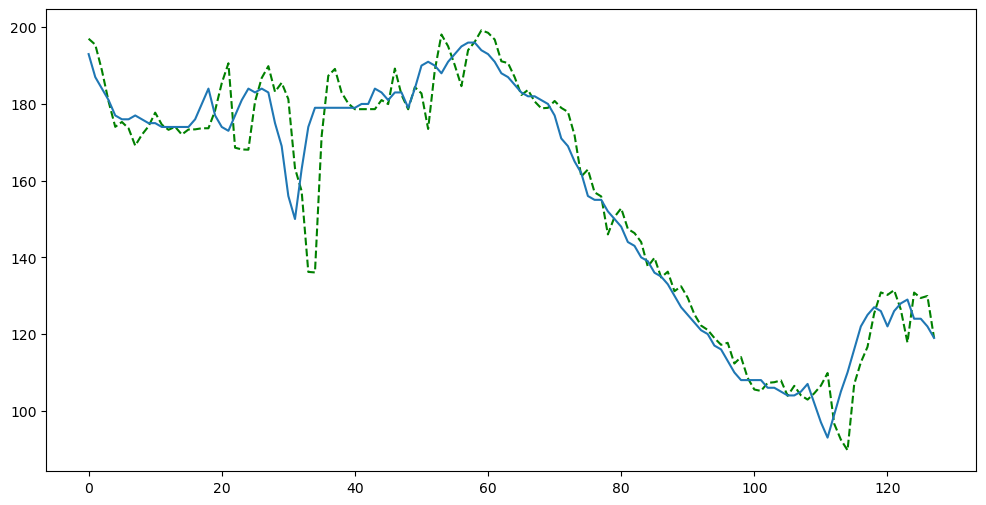

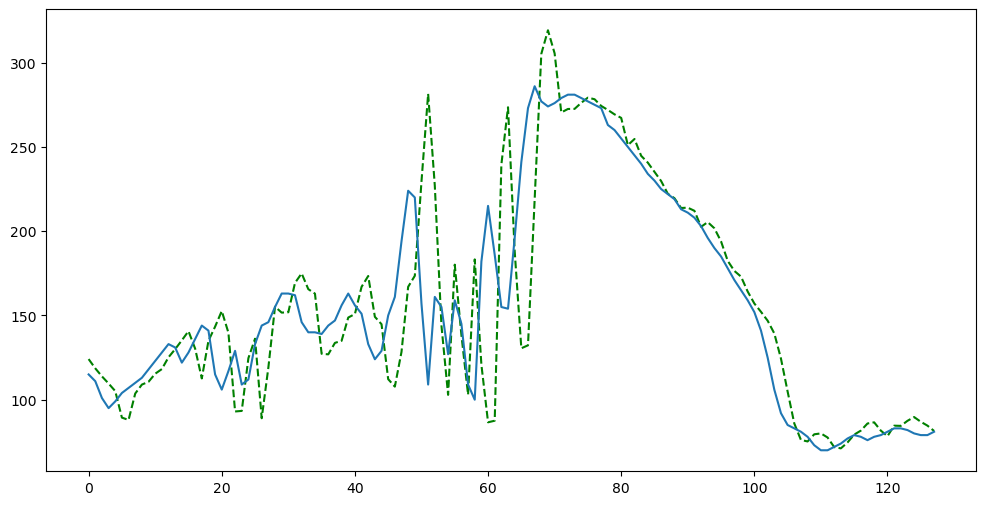

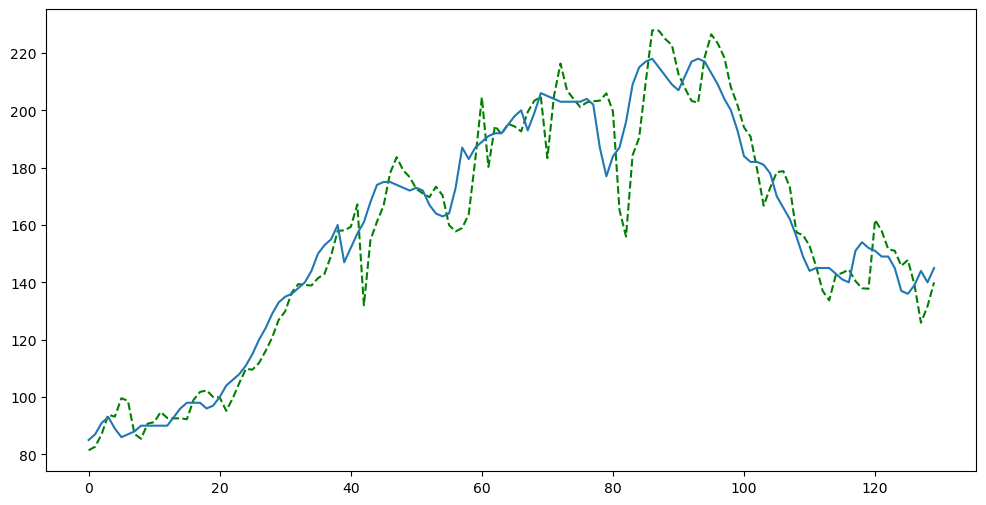

In [50]:
plot_model_predictions(normal_lstm_half_hour, half_hour_range, 20)